# `Insurance Price Prediction` using ML Algorithms

### Problem Statement
- The task is to predict the `price of insurance` based on the given features.
- Various ML/DL algorithms can be used to predict the price of insurance.
- In this work I will use `XGBoost`, and `Random Forest` algorithms to predict the price of insurance.

In [68]:
# necessary imports
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

import optuna

import git

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('darkgrid')
sns.set_palette('colorblind')

### 1. Exploratory Data Analysis (EDA)

In [3]:
repoPath = git.Repo('.', search_parent_directories=True)
dataPath = f'{repoPath.working_tree_dir}/data/insurance.csv'

Load the data

In [4]:
df = pd.read_csv(dataPath)

print(df.shape)
df.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Check for missing values, and duplicates

In [5]:
# check for missing values
# df.isnull().sum() # no missing values

# check for duplicates
#df.duplicated().sum()

# drop duplicates
df.drop_duplicates(inplace=True)

#### 1.1 Data Visualization

Let's check how age, sex, bmi, children, smoker, region influence the charges.

Distribution of charges, with respect to smokers/non-smokers

In [23]:
fig = make_subplots(rows=1, cols=4, subplot_titles=('Distribution of charges', 'Distribution of charges for smokers', 'Distribution of charges for non-smokers'))
fig.add_trace(px.histogram(df, x='charges', nbins=50, color_discrete_sequence=['green']).data[0], row=1, col=1)
fig.add_trace(px.histogram(df[df['smoker'] == 'yes'], x='charges', nbins=50, color_discrete_sequence=['red']).data[0], row=1, col=2)
fig.add_trace(px.histogram(df[df['smoker'] == 'no'], x='charges', nbins=50, color_discrete_sequence=['blue']).data[0], row=1, col=3)
# add boxplots
fig.add_trace(px.box(df, y='smoker', x='charges', color_discrete_sequence=['red', 'blue']).data[0], row=1, col=4)
fig.update_layout(showlegend=False)
# x axes range from 0 to the highest charge
fig.update_xaxes(range=[0, df['charges'].max()], row=1, col=1)
fig.update_xaxes(range=[0, df['charges'].max()], row=1, col=2)
fig.update_xaxes(range=[0, df['charges'].max()], row=1, col=3)
fig.show()

```
Non-smokers tend to have lower charges than smokers. Kind of self-explanatory!
```

How does sex affect the charges?

In [7]:
fig = px.box(df, x='sex', y='charges', color='sex', color_discrete_sequence=['red', 'blue'])
fig.update_layout(showlegend=False)
fig.show()

```
Seems like gender doesn't play much of a role in determining the charges.
```

How age is related to charges?

In [9]:
# scatter plot of charges vs age
fig = px.scatter(df, x='age', y='charges', color='smoker', trendline='ols')
fig.show()

```
There is a positive correlation between age and charges, for smokers and non-smokers.
```

How about BMI (Body Mass Index)?

In [10]:
fig = px.scatter(df, x='bmi', y='charges', color='smoker', trendline='ols')
fig.show()

There us a strong correlation between BMI and charges for smokers. For non-smokers, the correlation is not as strong. Age related issues? Old age drama with smoking?

Region?

In [11]:
# impact of region on charges
fig = px.box(df, x='region', y='charges', color='region')
fig.update_layout(showlegend=False)
fig.show()

```
There is no significant difference in charges based on region.
```

Children

In [12]:
# impact of children on charges
fig = px.box(df, x='children', y='charges', color='children')
fig.update_layout(showlegend=False)
fig.show()

```
No significant difference in charges based on number of children.
```

### 2. Data Preprocessing and Feature Engineering

#### 2.1 Label Encoding

Convert categorical variables to numerical using label encoding.

In [13]:
def encode_categorical(df):
    '''
    Function to encode categorical columns of a dataframe
    '''
    # instantiate LabelEncoder
    le = LabelEncoder()
    # encode
    for col in df.select_dtypes(include='object'):
        df[col] = le.fit_transform(df[col])
    return df   

In [14]:
df_encoded = encode_categorical(df.copy())
df_encoded.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


#### 2.2 Correlation Coefficient

Let's find the `Pearson correlation coefficient` between the features and the target variable.

In [15]:
# correlation coefficients
df_encoded.corr()['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.787234
age         0.298308
bmi         0.198401
children    0.067389
sex         0.058044
region     -0.006547
Name: charges, dtype: float64

So, not all features are highly correlated with the target variable. Let's select only the features that have a `correlation coefficient greater than 0.15`.

In [16]:
# abs correlation coefficients greater than 0.15 
columns = df_encoded.corr()[np.abs(df_encoded.corr()['charges']) > 0.15]['charges'].index
df_encoded = df_encoded[columns]
df_encoded.head()

,age,bmi,smoker,charges
0,19,27.900,1,16884.92400
1,18,33.770,0,1725.55230
2,28,33.000,0,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


As we have seen from the EDA section, sex, children, and region do not influence the charges much. Therefore, they are not good predictors for our model. However, we will keep them for now, and see how our model performs.

#### 2.3 Train-Test Split

Split the data into training and testing sets.

In [17]:
# train test split
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

We will employ tree-based models, we do not need to scale the data.

### 4. Model Training and Evaluation

Let's create XGBoost and Random Forest models to predict the price of insurance.

#### 4.1 Create the model functions

In [26]:
# XGBoost Regressor
def xgb_reg(X_train, y_train, X_test, y_test, params:dict={}):
    '''
    Function to train and evaluate an XGBoost Regressor
    '''
    # instantiate XGBRegressor
    xgb_reg = xgb.XGBRegressor(**params)
    
    # fit
    xgb_reg.fit(X_train, y_train)
    
    # predict
    y_pred = xgb_reg.predict(X_test)
    
    # evaluate
    score = {
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'y_pred': y_pred
    }

    return  score


# Random Forest Regressor
def random_forest_reg(X_train, y_train, X_test, y_test, params:dict={}):
    '''
    Function to train and evaluate a Random Forest Regressor
    '''
    # instantiate RandomForestRegressor
    rf_reg = RandomForestRegressor(**params)
    
    # fit
    rf_reg.fit(X_train, y_train)
    
    # predict
    y_pred = rf_reg.predict(X_test)
    
    # evaluate
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    score = {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    }
    
    return score

#### 4.2 Hyperparameter Tuning

We will use `Optuna` to tune the hyperparameters of the models.

In [27]:
# XGBoost
def objective_xgb(trial):
    device = 'gpu' if torch.cuda.is_available() else 'cpu'
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),

        'tree_method': 'gpu_hist' if device == 'gpu' else 'auto',
        'objective': 'reg:squarederror',
        'random_state': 123
    }
    
    # train and evaluate
    score = xgb_reg(X_train, y_train, X_test, y_test, params)
    
    return score['mse']

# Random Forest
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'random_state': 123
    }
    
    # train and evaluate
    score = random_forest_reg(X_train, y_train, X_test, y_test, params)
    
    return score['mse']


In [28]:
# XGBoost
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=5)

# Random Forest
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=5)

[I 2024-04-01 14:55:36,758] A new study created in memory with name: no-name-43a2c2a0-b62e-4689-a7f0-45ca222daa5e
[I 2024-04-01 14:55:36,966] Trial 0 finished with value: 26943912.128872883 and parameters: {'n_estimators': 466, 'max_depth': 6, 'learning_rate': 0.0466273714675318, 'subsample': 0.6}. Best is trial 0 with value: 26943912.128872883.
[I 2024-04-01 14:55:37,048] Trial 1 finished with value: 23500365.81523302 and parameters: {'n_estimators': 268, 'max_depth': 5, 'learning_rate': 0.08303608065782928, 'subsample': 0.8}. Best is trial 1 with value: 23500365.81523302.
[I 2024-04-01 14:55:37,113] Trial 2 finished with value: 29175614.564688824 and parameters: {'n_estimators': 171, 'max_depth': 6, 'learning_rate': 0.14115995528866312, 'subsample': 0.7}. Best is trial 1 with value: 23500365.81523302.
[I 2024-04-01 14:55:37,181] Trial 3 finished with value: 20012968.15725733 and parameters: {'n_estimators': 135, 'max_depth': 7, 'learning_rate': 0.035235155409055384, 'subsample': 0.6}

#### 4.2 Score

In [29]:
# XGBoost Regressor
xgb_score = xgb_reg(X_train, y_train, X_test, y_test, study_xgb.best_params)

# Random Forest Regressor
rf_score = random_forest_reg(X_train, y_train, X_test, y_test, study_rf.best_params)

#### 4.3 Visualize the results

Predicted vs Actual

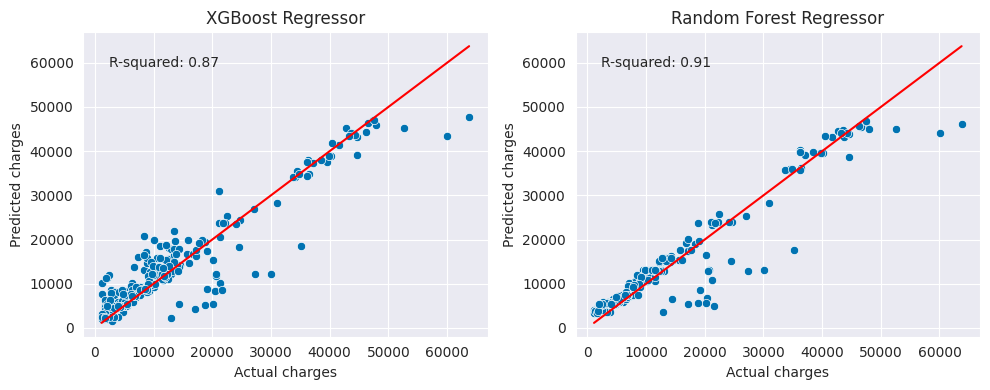

In [63]:
# predicted vs actual charges
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x=y_test, y=xgb_score['y_pred'], ax=ax[0])
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax[0])
ax[0].set_title('XGBoost Regressor')
ax[0].set_xlabel('Actual charges')
ax[0].set_ylabel('Predicted charges')
ax[0].text(0.2, 0.9, f"R-squared: {xgb_score['r2']:.2f}", ha='center', va='center', transform=ax[0].transAxes)
           
sns.scatterplot(x=y_test, y=rf_score['y_pred'], ax=ax[1])
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax[1])
ax[1].set_title('Random Forest Regressor')
ax[1].set_xlabel('Actual charges')
ax[1].set_ylabel('Predicted charges')
ax[1].text(0.2, 0.9, f"R-squared: {rf_score['r2']:.2f}", ha='center', va='center', transform=ax[1].transAxes)

plt.tight_layout()
plt.show()

Ideally, the points should be close to the line `y=x`. The closer the points are to the line, the better the model.

Standardized Residuals 

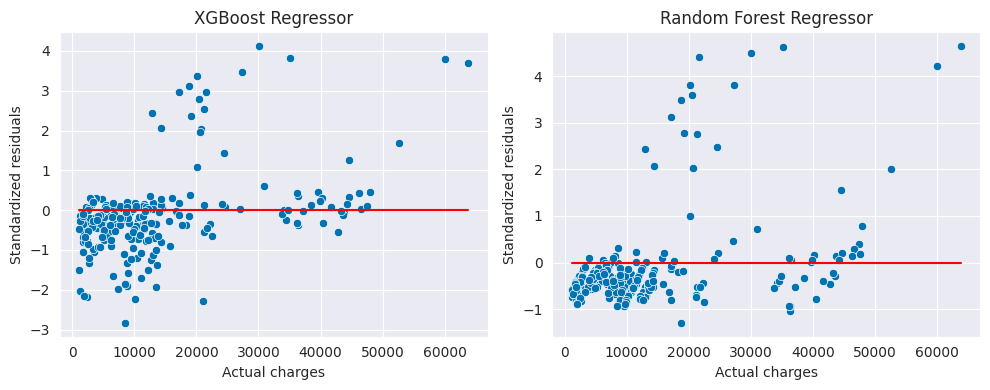

In [66]:
# residuals
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
residuals_xgb = y_test - xgb_score['y_pred']
std_res_xgb = residuals_xgb / residuals_xgb.std()
sns.scatterplot(x=y_test, y=std_res_xgb, ax=ax[0])
sns.lineplot(x=y_test, y=0, color='red', ax=ax[0])
ax[0].set_title('XGBoost Regressor')
ax[0].set_xlabel('Actual charges')
ax[0].set_ylabel('Standardized residuals')

residuals_rf = y_test - rf_score['y_pred']
std_res_rf = residuals_rf / residuals_rf.std()
sns.scatterplot(x=y_test, y=std_res_rf, ax=ax[1])
sns.lineplot(x=y_test, y=0, color='red', ax=ax[1])
ax[1].set_title('Random Forest Regressor')
ax[1].set_xlabel('Actual charges')
ax[1].set_ylabel('Standardized residuals')

plt.tight_layout()
plt.show()

- The distance from the line at 0 says how bad the prediction was for that point. The closer the points are to the line, the better the model.
- Positive values indicate that the prediction was higher than the actual value, and negative values indicate that the prediction was lower than the actual value.

Ideally, residual plots should look like:

<img src="/home/pops/myProjects/PredEngine/data/imgs/ideal_resiudal_plot.png" width="300">

That is,
- they’re pretty symmetrically distributed, tending to cluster towards the middle of the plot.
- they’re clustered around the lower single digits of the y-axis (e.g., 0.5 or 1.5, not 30 or 150).
- in general, there aren’t any clear patterns.

Example of a residual plots that dont meet the above criteria:

<img src="/home/pops/myProjects/PredEngine/data/imgs/bad_residual_plot.png" width="300">

Reference: [Residual Plots](https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/)

